In [2]:
import torch
print("Pytorch version: " + torch.__version__)
print("ROCM HIP version: " + torch.version.hip)
torch.cuda.set_device('cuda:0')

from unyt import *
from synthesizer.parametric import SFH

%load_ext autoreload
%autoreload 2

Pytorch version: 2.4.1
ROCM HIP version: 6.1.40093-e3dc58bf0


In [1]:
import harmonic as hm
from harmonic.model import RealNVPModel

In [17]:
from harmonic.model import ModifiedGaussianMixtureModel

In [ ]:
sed_path = 'Yggdrasil/PopIII.1_fcov_1_SFR_10M_yr_Spectra'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import re

def load_seds_from_file(filename):
    """
    Load multiple SED datasets from a text file.
    
    Parameters:
    -----------
    filename : str
        Path to the text file containing multiple SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    current_metadata = {}
    current_wavelength = []
    current_flux = []
    
    with open(filename, 'r') as file:
        lines = file.readlines()
        
        in_data_section = False
        
        for i, line in enumerate(lines):
            line = line.strip()
            
            # Skip empty lines
            if not line:
                continue
            
            # Check if this is the start of a new SED section
            if "Age (Myr):" in line and in_data_section:
                # Save the current SED data before starting a new one
                if current_wavelength and current_flux:
                    seds.append({
                        "metadata": current_metadata.copy(),
                        "wavelength": np.array(current_wavelength),
                        "flux": np.array(current_flux)
                    })
                    
                # Reset for the new SED
                current_metadata = {}
                current_wavelength = []
                current_flux = []
                in_data_section = False
            
            # Process data section
            if in_data_section:
                # Handle potential formatting issues in the data
                line = line.replace("'", "").strip()
                parts = re.split(r'\s+', line)
                
                if len(parts) >= 2:
                    try:
                        wl = float(parts[0])
                        fl = float(parts[1])
                        current_wavelength.append(wl)
                        current_flux.append(fl)
                    except ValueError:
                        # Skip lines that can't be parsed as numbers
                        pass
            
            # Parse metadata
            elif "Wavelength (AA)" in line and "Flux" in line:
                in_data_section = True
            elif ":" in line:
                key, value = line.split(":", 1)
                current_metadata[key.strip()] = value.strip()
            elif "Wavelength unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Wavelength unit"] = parts[1].strip() if ":" in line else parts[2].strip()
            elif "Energy unit" in line:
                parts = line.split(":", 1) if ":" in line else line.split()
                if len(parts) > 1:
                    current_metadata["Energy unit"] = parts[1].strip() if ":" in line else parts[2].strip()
    
    # Don't forget to add the last SED
    if current_wavelength and current_flux:
        seds.append({
            "metadata": current_metadata,
            "wavelength": np.array(current_wavelength),
            "flux": np.array(current_flux)
        })

    
    for i, sed in enumerate(seds):
        # Convert wavelength and flux to unyt arrays with appropriate units
        sed["wavelength"] = unyt_array(sed["wavelength"], units=Angstrom)
        sed["flux"] = unyt_array(sed["flux"], units=erg / (s * Angstrom))
        # convert to fnu (erg/s*Hz)
        sed["flux"] = (sed["flux"] * sed["wavelength"]**2/ (2.99792458e9  * m/s)).to(erg / (s * Hz))
        sed['metadata']['Energy unit'] = 'erg/s/Hz'

    
    return seds

def load_seds_from_files(filenames):
    """
    Load multiple SED datasets from a list of text files.
    
    Parameters:
    -----------
    filenames : list
        List of paths to text files containing SED datasets
        
    Returns:
    --------
    list
        List of dictionaries, each containing metadata and wavelength/flux data for one SED
    """
    seds = []
    
    for filename in filenames:
        seds.extend(load_seds_from_file(filename))
    
    return seds

def plot_sed(sed_data, ax=None, label=None):
    """
    Plot a single SED dataset.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing wavelength and flux data
    ax : matplotlib.axes.Axes, optional
        Axes to plot on. If None, a new figure is created.
    label : str, optional
        Label for the plot legend
    
    Returns:
    --------
    matplotlib.axes.Axes
        The axes on which the plot was drawn
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a label if not provided
    if label is None and "Age (Myr)" in sed_data["metadata"]:
        label = f"Age: {float(sed_data['metadata']['Age (Myr)']):.4g} Myr"
    
    ax.loglog(sed_data["wavelength"], sed_data["flux"], label=label)
    
    ax.set_xlabel(f'Wavelength ({sed_data["metadata"].get("Wavelength unit", "AA")})')
    ax.set_ylabel(f'Flux ({sed_data["metadata"].get("Energy unit", "erg")}')
    ax.set_title('Spectral Energy Distribution')
    ax.grid(True, which="both", ls="--", alpha=0.3)
    
    if label:
        ax.legend()
    
    return ax

def plot_multiple_seds(seds_data, max_seds=None):
    """
    Create a plot comparing multiple SEDs.
    
    Parameters:
    -----------
    seds_data : list
        List of SED data dictionaries
    max_seds : int, optional
        Maximum number of SEDs to plot. If None, all SEDs are plotted.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing the plot
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Limit the number of SEDs to plot if specified
    if max_seds is not None:
        seds_to_plot = seds_data[:max_seds]
    else:
        seds_to_plot = seds_data
    
    for i, sed in enumerate(seds_to_plot):
        age = float(sed["metadata"].get("Age (Myr)", f"SED {i+1}"))
        label = f"Age: {age:.4g} Myr"
        plot_sed(sed, ax=ax, label=label)
    
    plt.tight_layout()
    return fig

def print_sed_summary(sed_data, index=None):
    """
    Print a summary of SED metadata and data statistics.
    
    Parameters:
    -----------
    sed_data : dict
        Dictionary containing SED metadata and data
    index : int, optional
        Index of the SED (for display purposes)
    """
    if index is not None:
        print(f"\nSED #{index+1}:")
    else:
        print("\nSED Summary:")
    
    # Print metadata
    for key, value in sed_data["metadata"].items():
        print(f"  {key}: {value}")
    
    # Print data statistics
    print(f"\n  Data points: {len(sed_data['wavelength'])}")
    print(f"  Wavelength range: {sed_data['wavelength'].min()} - {sed_data['wavelength'].max()} {sed_data['metadata'].get('Wavelength unit', 'AA')}")
    print(f"  Flux range: {sed_data['flux'].min():.3e} - {sed_data['flux'].max():.3e} {sed_data['metadata'].get('Energy unit', 'erg')}")

# Example usage
if __name__ == "__main__":
    # Replace 'your_sed_file.txt' with the path to your file
    seds = load_seds_from_file(sed_path)
    
    print(f"Loaded {len(seds)} SED datasets from file.")
    
    # Print summary of first few SEDs
    max_display = min(3, len(seds))
    for i in range(max_display):
        print_sed_summary(seds[i], index=i)
    
    if len(seds) > max_display:
        print(f"\n...and {len(seds) - max_display} more SED datasets.")
    
    # Plot all SEDs on the same graph (limit to 10 for readability)
    max_plot = min(10, len(seds))
    if max_plot < len(seds):
        print(f"\nPlotting first {max_plot} of {len(seds)} SEDs...")
    
    fig = plot_multiple_seds(seds, max_seds=max_plot)
    plt.show()
    

NameError: name 'sed_path' is not defined

In [ ]:
# do we even need to give muv? Or is shape enough?

# Can simply give normalized photometry. 
# If we give muv it will be in log10(nJy) units. 
# Giving normalized photometry allows us to pass in negative photometry better


features = filter_codes + \
            ["JWST/NIRCam.F115W-JWST/NIRCam.F150W", "JWST/NIRCam.F150W-JWST/NIRCam.F277W", "JWST/NIRCam.F277W-JWST/NIRCam.F444W"] + \
            ['muv', 'z']


In [ ]:
def compute_photometry_from_sed(sed_data, filterset, redshift, supress_lya=False, plot=False):
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

    norm_arr = np.full(len(sed_data), np.nan)
    phot_data_arr = np.full((len(sed_data), len(filterset)), np.nan)

    for pos, sed_i in enumerate(sed_data):
        if supress_lya:
            # Find pixel closest to 1216 and set to next pixel
            index = np.argmin(np.abs(sed_i['wavelength'] - 1216 * Angstrom))
            sed_i['flux'][index] = sed_i['flux'][index + 1]
           
        sed = Sed(lam = sed_i['wavelength'], lnu = sed_i['flux'])
        sed.get_fnu(cosmo=cosmo, z = redshift, igm=Inoue14)
        phot = sed.get_photo_fnu(filters=filterset)

        muv = sed.get_lnu_at_lam(15000 * Angstrom)
        # muv is rest-frame luminosity at 15000 Angstrom. Apply cosmological dimming
        # to get apparent magnitude

        muv = (muv * (1 + redshift)**2 / (4 * np.pi * (cosmo.luminosity_distance(redshift).to(u.m).value *m)**2)).to(nJy)

        phot_data = phot.photo_fnu

        norm_arr[pos] = np.log10(muv.value)

        phot_data_arr[pos] = phot_data.value

        if plot:
            wav = phot.filters.pivot_lams
            ax.plot(wav, phot_data/muv, label=f"z={redshift:.2f}")
            ax.set_title(f"SED Photometry (z={redshift:.2f})")
            ax.set_xlabel("Wavelength (Angstrom)")
            ax.set_ylabel("Photometry (normalized to 15000 Angstrom)")
        
    return phot_data_arr, norm_arr


def generate_feature_array(feature_names, seds, redshifts, filterset, supress_lya=False):
    
    feature_array = np.full((len(seds)*len(redshifts), len(feature_names)), np.nan)

    sum_indexes = []
    opp_types = []

    for feature_name in feature_names:
        if '-' in feature_name:
            filters = feature_name.split('-')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.subtract)
        elif '+' in feature_name:
            filters = feature_name.split('+')
            sum_indexes.append([filter_codes.index(filters[0]), filter_codes.index(filters[1])])
            opp_types.append(np.add)
        else:
            pass
            
    for i, redshift in enumerate(redshifts):
        for j, sed in enumerate(seds):
            phot_data_arr, norm_arr = compute_photometry_from_sed([sed], filterset, redshift, supress_lya=supress_lya)
            colors = []
            for k, sum_index in enumerate(sum_indexes):
                colors.append(opp_types[k](phot_data_arr[0][sum_index[0]], phot_data_arr[0][sum_index[1]]))
                
            feature_array[i * len(seds) + j] = np.concatenate((phot_data_arr[0], colors, [norm_arr[0], redshift]))

    return feature_array

redshifts = np.arange(6, 15, 0.1)

feature_array = generate_feature_array(features, seds, redshifts, filterset, supress_lya=True)

In [ ]:
# Split into train/test and build loaders
test_split = 0.1
n_samples = len(feature_array)

# Model 1
mask1 = np.random.rand(n_samples) > test_split
x1_train, x1_test = feature_array[mask1], feature_array[~mask1]
theta1_train, theta1_test = theta1[mask1], theta1[~mask1]


# Build loaders
loader1_train = NumpyLoader(x1_train, theta1_train)
loader1_test = NumpyLoader(x1_test, theta1_test)


In [ ]:
# Training scripts to train NPE/NLE with LtU-ILI
def train_nde(loader, prior_mu, engine='NLE'):
    # define a prior
    prior = ili.utils.IndependentNormal(
        loc=prior_mu,
        scale=1*np.ones(Ndim),
        device=device
    )
    # instantiate your neural networks to be used as an ensemble
    nets = [
        ili.utils.load_nde_sbi(
            engine=engine, model='mdn', hidden_features=50, num_components=4),
    ]
    # define training arguments
    train_args = {
        'training_batch_size': 64,
        'learning_rate': 5e-4
    }
    # initialize the trainer
    runner = InferenceRunner.load(
        backend='sbi',
        engine=engine,
        prior=prior,
        nets=nets,
        device=device,
        train_args=train_args,
    )
    # train the model
    posterior_ensemble, summaries = runner(loader=loader)
    return posterior_ensemble, summaries

In [ ]:
# Train Neural Likelihood Estimation
nle1, summ_nle1 = train_nde(loader1_train, mu1, 'NLE')
nle2, summ_nle2 = train_nde(loader2_train, mu2, 'NLE')

# Train Neural Posterior Estimation
npe1, summ_npe1 = train_nde(loader1_train, mu1, 'NPE')
npe2, summ_npe2 = train_nde(loader2_train, mu2, 'NPE')

[2.000e+08 7.750e+08 1.350e+09 1.925e+09 2.500e+09] [1.000e+07 2.575e+08 5.050e+08 7.525e+08 1.000e+09]
0.0212308338535094 19.114278672818426 Myr
0.005479457473948389 20.468403611771564 Myr
0.0031456291057436127 21.023380324379215 Myr
0.0022060281696146405 21.378196671246396 Myr
0.0016986424681469184 21.639559454206832 Myr
0.5146691037595844 19.37871221085626 Myr
0.14045591994136253 20.488101452764194 Myr
0.0808778449719188 21.029911655203893 Myr
0.05676302259867234 21.38141384542069 Myr
0.043720760820310484 21.641468073747273 Myr
0.8963555085978228 19.917281122300306 Myr
0.27203905001086565 20.54237883204896 Myr
0.15794271887375444 21.048316331841985 Myr
0.11108753873920067 21.3905322459456 Myr
0.08563632442627712 21.646890148881532 Myr
1.1799047912581515 20.506003240946253 Myr
0.3976445336079739 20.626494762425658 Myr
0.23374711408334964 21.078008142739094 Myr
0.16496461449919148 21.405405128723025 Myr
0.12734524705990888 21.655773380769315 Myr
1.3990293227261892 21.07111097036023 My

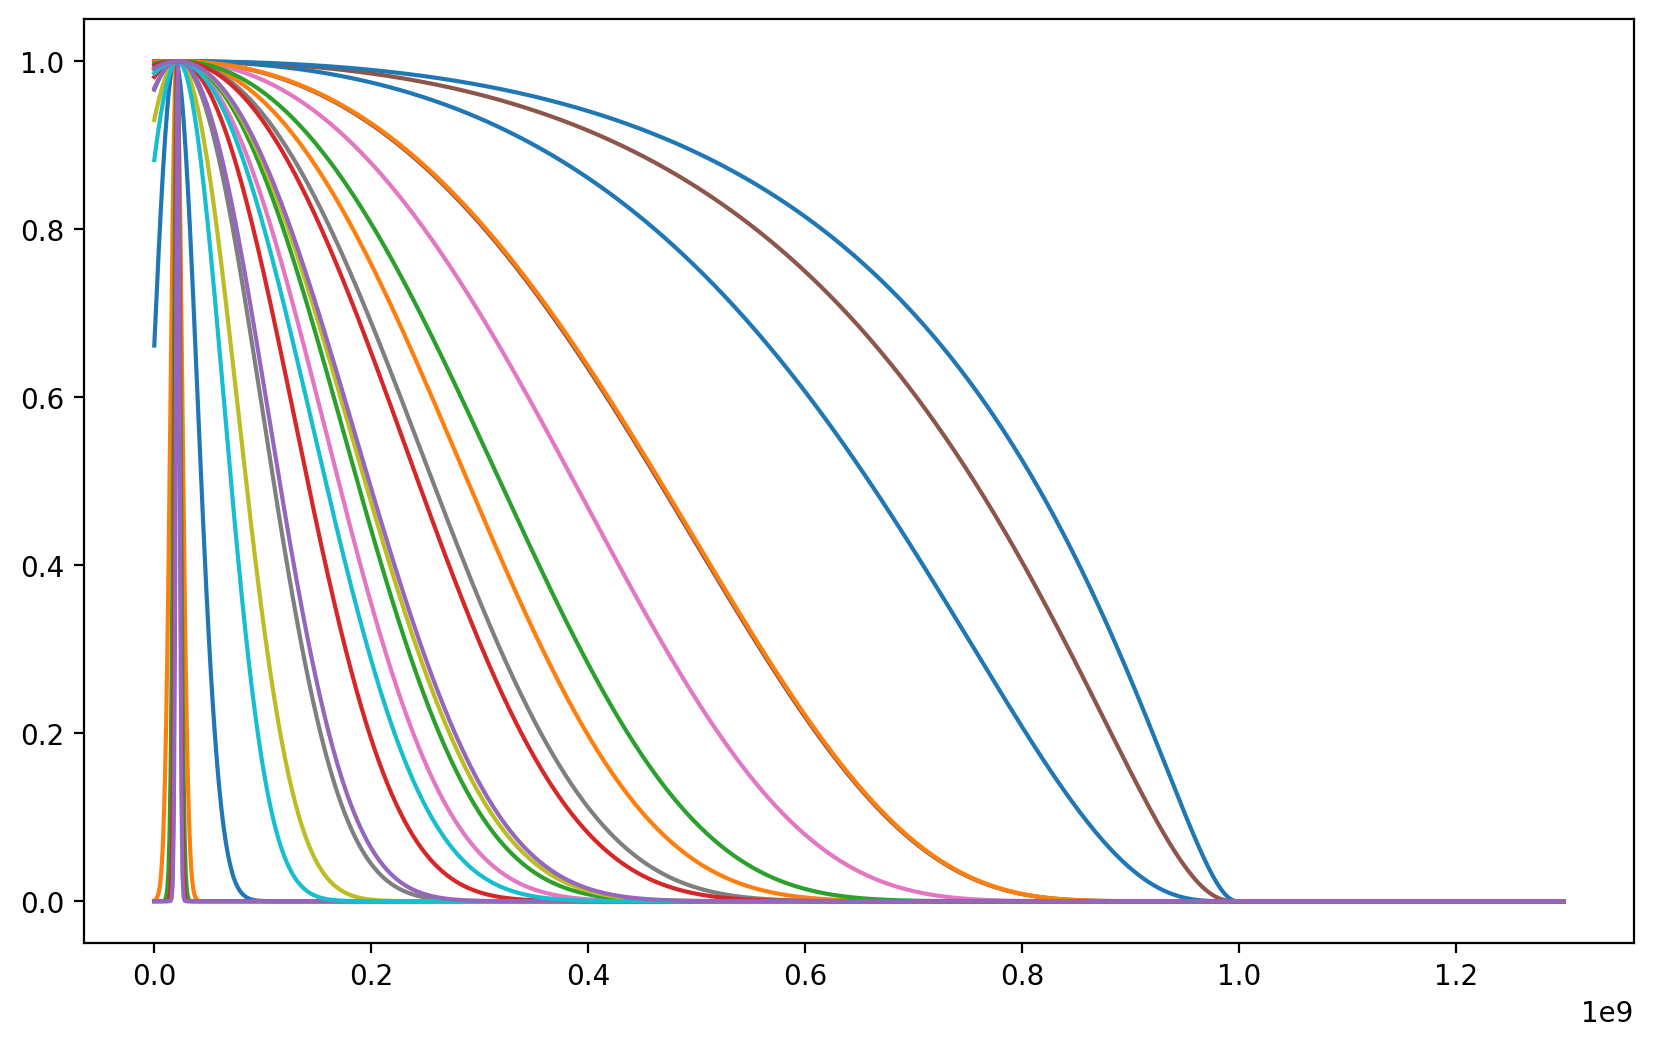

In [11]:
from scipy.optimize import fsolve
def lognorm_equations(p, consts):
    """ Equations for finding the tau and T0 for a lognormal SFH given
    some tmax and FWHM. Needed to transform variables. """

    tau_solve, T0_solve = p

    xmax, h = consts

    tau = np.exp(T0_solve - tau_solve**2) - xmax
    t0 = xmax*(np.exp(0.5*np.sqrt(8*np.log(2)*tau_solve**2))
               - np.exp(-0.5*np.sqrt(8*np.log(2)*tau_solve**2))) - h

    return (tau, t0)


tmaxes = np.linspace(200, 2500, 5) * Myr 
tmaxes = tmaxes.to(yr).to_value()

FWHMs = np.linspace(10, 1000, 5) * Myr
FWHMs = FWHMs.to(yr).to_value()

print(tmaxes, FWHMs)


# Create a grid of tmax and FWHM values

tmax_grid, FWHM_grid = np.meshgrid(tmaxes, FWHMs)
# Flatten the grid for easier processing
tmax_flat = tmax_grid.flatten()
FWHM_flat = FWHM_grid.flatten() 

# Create a list to store the results
results = []
# Loop through the grid and calculate tau and T0 for each combination


fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')

max_age=1000*Myr

for tmax, fwhm in zip(tmax_flat, FWHM_flat):
    # Define the constants for the equations
    consts = (tmax, fwhm)
    
    # Use fsolve to find the roots of the equations
    
    tau_guess = fwhm/(2*tmax*np.sqrt(2*np.log(2)))
    t0_guess = np.log(tmax) + fwhm**2/(8*np.log(2)*tmax**2)

    tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
                        args=([tmax, fwhm]))
    
    t0 = t0 * Myr

    print(tau, t0)
    sfh = SFH.LogNormal(tau=tau, peak_age=t0, max_age=max_age, min_age=0 * Myr)
    age, sfr = sfh.calculate_sfh(t_range=(0, 1.3*max_age.to(yr)), dt=1e6*yr)                                       
    sfr = sfr / sfr.max()
    ax.plot(age, sfr, label=f"tau={tau:.2f}")
    

    # add secondary axis showing redshift





In [ ]:
def lognormal(self, sfr, param):
    if "tmax" in list(param) and "fwhm" in list(param):
        tmax, fwhm = param["tmax"]*10**9, param["fwhm"]*10**9

        tau_guess = fwhm/(2*tmax*np.sqrt(2*np.log(2)))
        t0_guess = np.log(tmax) + fwhm**2/(8*np.log(2)*tmax**2)

        tau, t0 = fsolve(lognorm_equations, (tau_guess, t0_guess),
                            args=([tmax, fwhm]))

    else:
        tau, t0 = par_dict["tau"], par_dict["t0"]

    mask = self.ages < self.age_of_universe
    t = self.age_of_universe - self.ages[mask]

    sfr[mask] = ((1./np.sqrt(2.*np.pi*tau**2))*(1./t)
                    * np.exp(-(np.log(t) - t0)**2/(2*tau**2)))

In [ ]:

        # Set the model parameters
        self.peak_age = peak_age.to("yr").value
        self.tau = tau
        self.max_age = max_age.to("yr").value
        self.min_age = min_age.to("yr").value

        # Calculate the relative ages and peak for the calculation
        self.tpeak = self.max_age - self.peak_age
        self.t_0 = np.log(self.tpeak) + self.tau**2

    def _sfr(self, age):
        """Get the amount SFR weight in a single age bin.

        Args:
            age (float):
                The age (in years) at which to evaluate the SFR.
        """
        if (age < self.max_age) & (age >= self.min_age):
            norm = 1.0 / (self.max_age - age)
            exponent = (
                (np.log(self.max_age - age) - self.t_0) ** 2 / 2 / self.tau**2
            )
            return norm * np.exp(-exponent)

        return 0.0

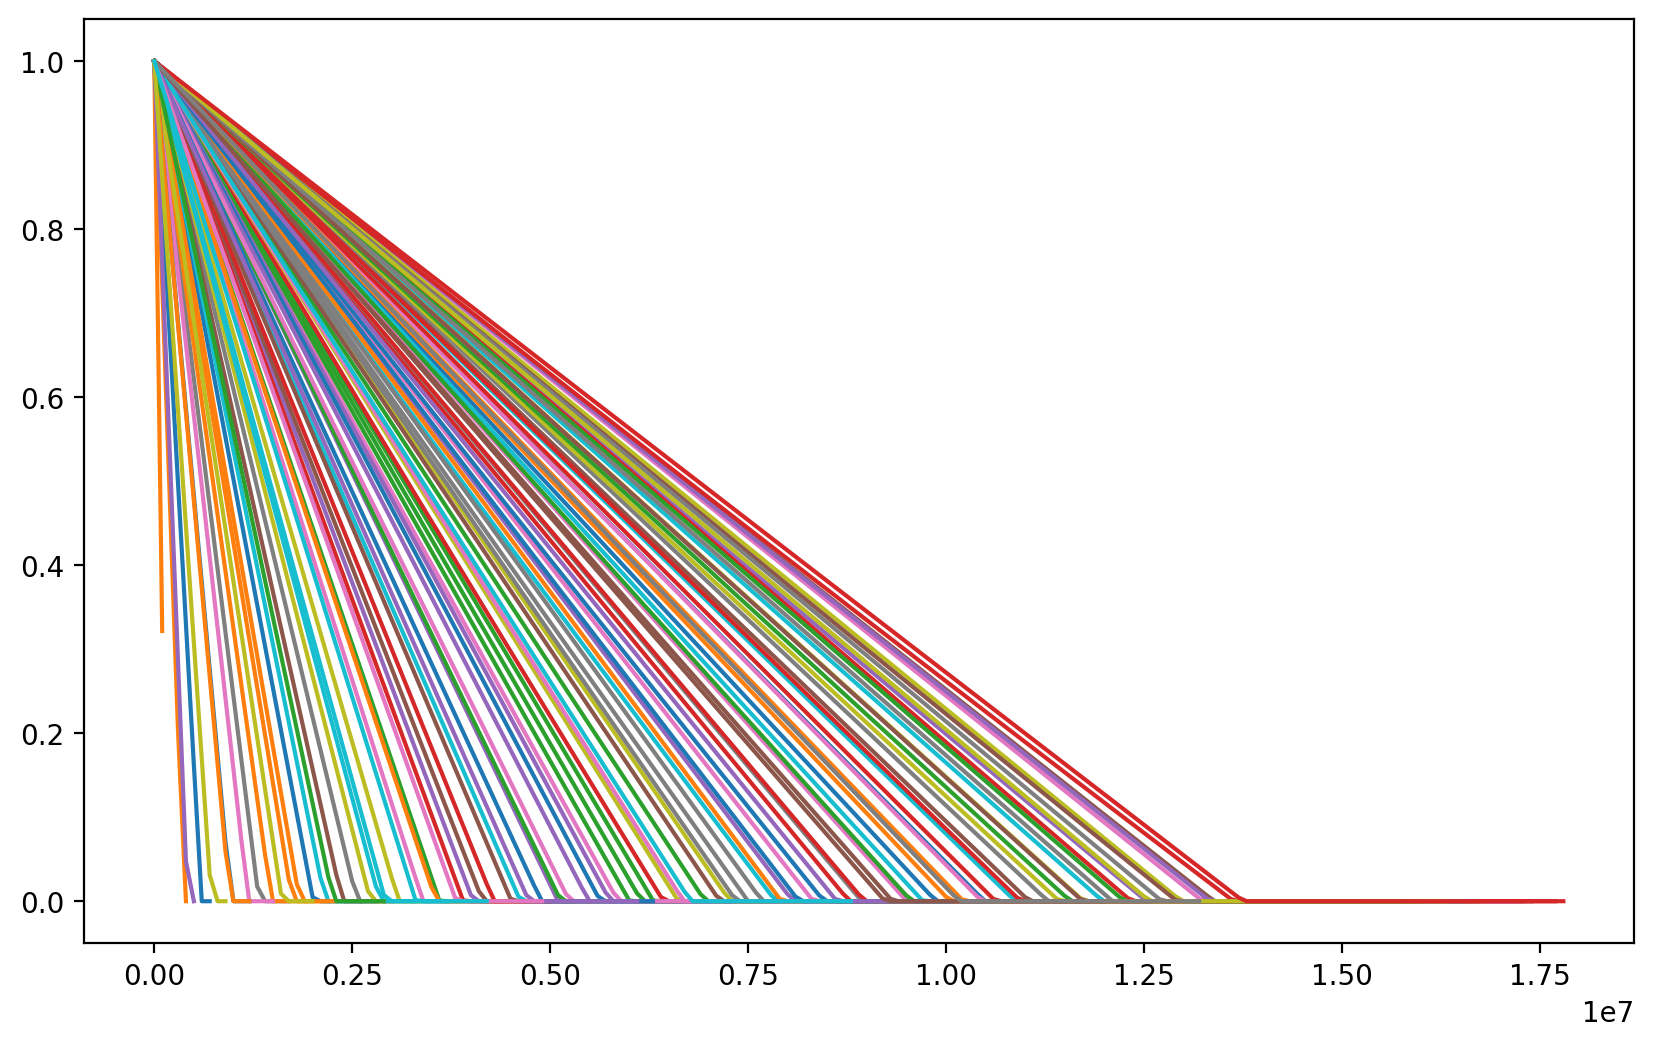

In [22]:
from unyt import Myr, Gyr, yr

max = 13.8 * Gyr

sfh_type = SFH.DelayedExponential
tau = (300, 10_000) * Myr
max_age = (0, max) * Myr

def plot_sfh(sfh_type, tau, max_age, min_age=0 * Myr):
    sfh = sfh_type(tau=tau, max_age=max_age, min_age=min_age)
    age, sfr = sfh.calculate_sfh(t_range=(0, 1.3*max_age.to(yr)), dt=1e5*yr)                                       
    sfr = sfr / sfr.max()
    plt.plot(age, sfr)
    
from ltu_ili_testing import draw_from_hypercube

param_ranges = {
    'tau': tau,
    'max_age': max_age,
}
output = draw_from_hypercube(N=100, param_ranges=param_ranges)

fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k')
for i in range(len(output)):
    plot_sfh(sfh_type, output[:, 0][i]*Myr, output[:, 1][i]*Myr)


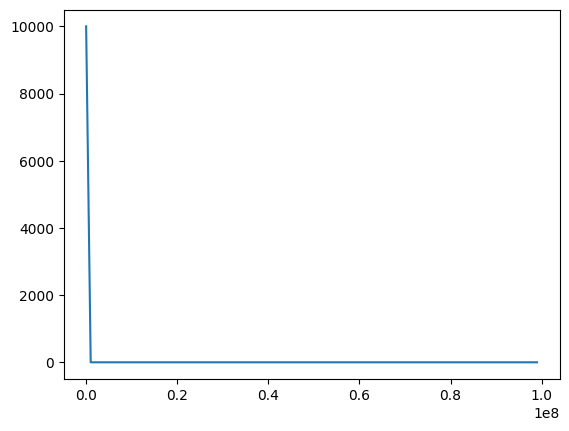

In [33]:
model = SFH.DelayedExponential

# Define the parameters for the model

sfh = model(max_age=0.01*Myr, tau=1000*Myr)
sfh.plot_sfh(t_range=(0, 1e8))


0.36669664851854394 Gyr


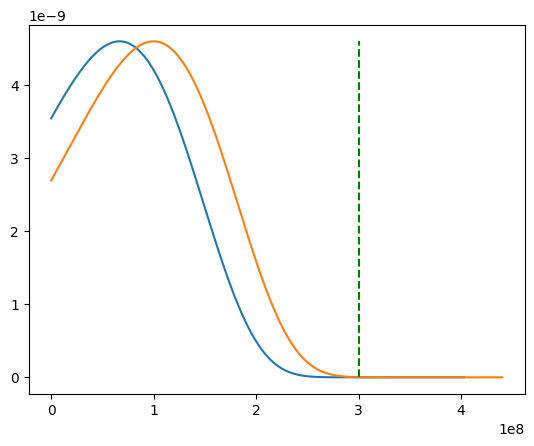

In [30]:
from synthesizer.parametric import SFH
from matplotlib import pyplot as plt
from unyt import Myr, Gyr, yr
from astropy.cosmology import Planck18 as cosmo


tmax = 300 * Myr
redshift = 12
max_age = cosmo.age(redshift).to('Gyr').value * Gyr
print(max_age)
sfh = SFH.LogNormal(fwhm=200*Myr, tpeak_after_max=tmax, max_age=max_age)
t, sfr = sfh.calculate_sfh(t_range=(0, 1.1*max_age.to(yr)))
plt.plot(t, sfr)

tmax = 300 * Myr
max_age = 400 * Myr
sfh = SFH.LogNormal(fwhm=200*Myr, tpeak_after_max=tmax, max_age=max_age)
t, sfr = sfh.calculate_sfh(t_range=(0, 1.1*max_age.to(yr)))
plt.plot(t, sfr)


plt.vlines(tmax.to(yr).value, 0, sfr.max(), color='g', linestyle='--', label='tmax')    

Integral of dN/dlogq from 1e-08 to 0.01: 0.029730906358507985


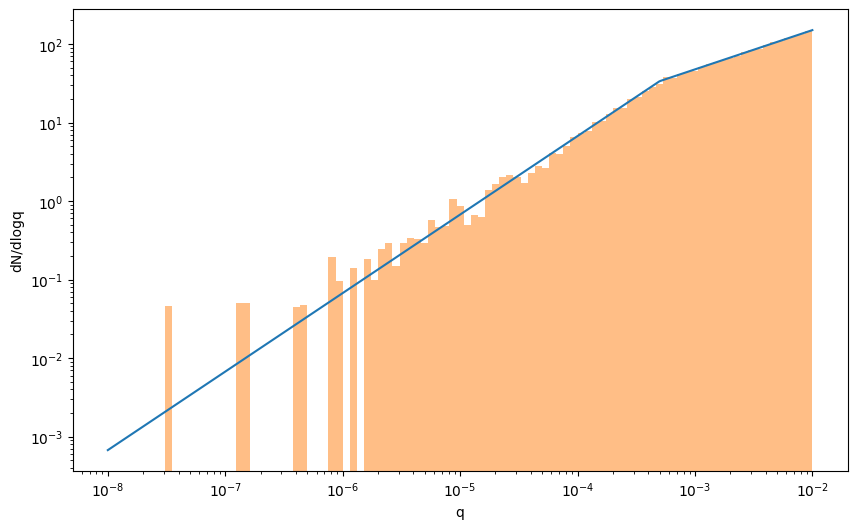

In [32]:
qmin = 1e-8
qmax = 1e-2
qbrk = 5e-4
n1 = 1
n2 = 0.5
norm = 1

from matplotlib import pyplot as plt
import numpy as np


q = np.logspace(np.log10(qmin), np.log10(qmax), 1000)

def dN_dlogq(q, qbrk=qbrk, qmin=qmin, qmax=qmax, norm=norm):
    """Power-law distribution with a break at qbrk"""
    if q < qbrk:
        return (q/qbrk)**(n1) * norm
    else:
        return (q/qbrk)**(n2) * norm

# Integrate a constant and normalise to 1 then plot

from scipy.integrate import quad
def integrate_dN_dlogq(q, qbrk=qbrk, qmin=qmin, qmax=qmax):
    """Integrate dN/dlogq from qmin to qmax"""
    integral, _ = quad(dN_dlogq, qmin, qmax, args=(qbrk, norm))
    return integral

# Calculate the integral
integral = integrate_dN_dlogq(qmin, qbrk, qmin, qmax)
print(f"Integral of dN/dlogq from {qmin} to {qmax}: {integral}")


norm = 1 / integral

# Now plot the distribution
plt.figure(figsize=(10, 6))

plt.loglog(q, [dN_dlogq(qi, qbrk, qmin, qmax) * norm for qi in q], label='dN/dlogq')

plt.xlabel('q')
plt.ylabel('dN/dlogq')

# sample randomly and plot a histogram

n_samples = 100_000
samples = np.random.uniform(qmin, qmax, n_samples)
dN_dlogq_samples = [dN_dlogq(qi, qbrk, qmin, qmax)*norm for qi in samples]
bins = np.logspace(np.log10(qmin), np.log10(qmax), 100)
plt.hist(samples, bins=bins, weights=dN_dlogq_samples, density=True, stacked=False, alpha=0.5, label='Sampled Histogram')
plt.xscale('log')
plt.yscale('log')
    

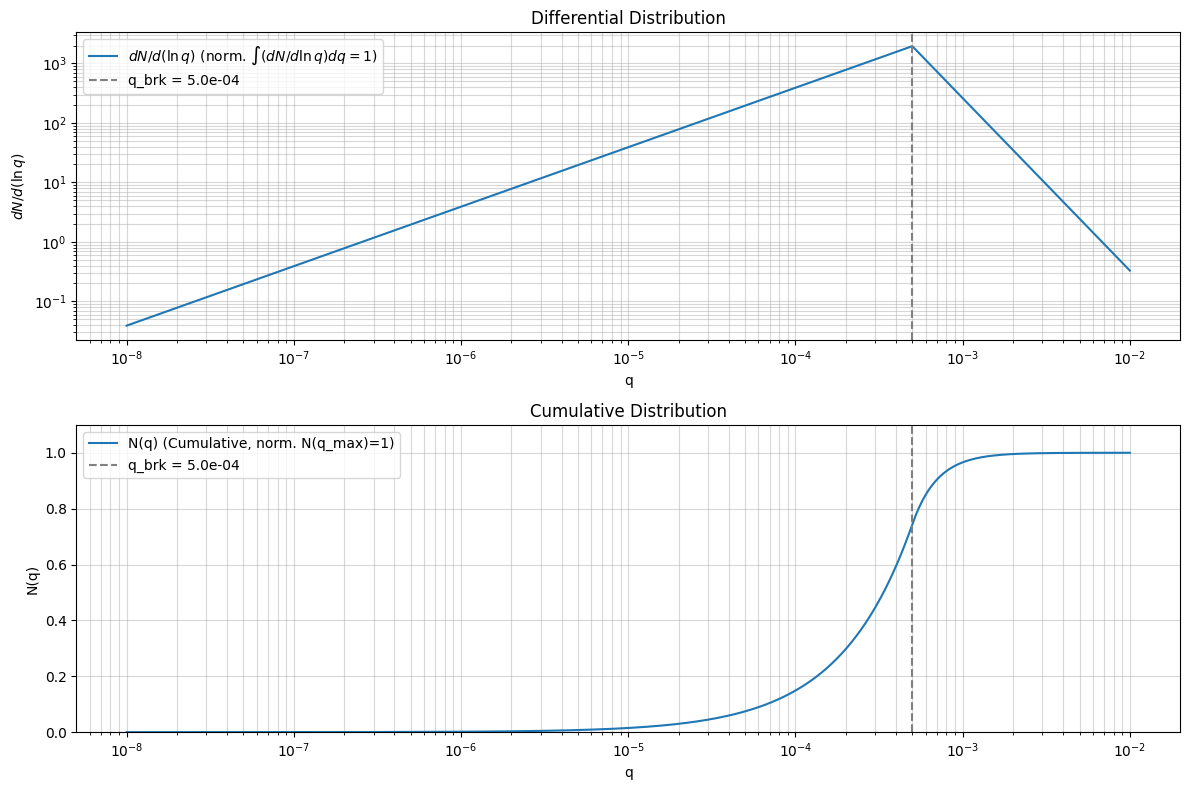

qmin = 1e-08, qmax = 0.01, qbrk = 0.0005, n1 = 1.0, n2 = -2.9
Integral of kernel over dq (for dN/dlogq plot norm): 5.1227e-04
Total unnormalized N (integral of kernel/q dq): 1.3447e+00
N(q_max) using analytical integration: 1.0000


In [8]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import quad

# Original parameters
qmin: float = 1e-8
qmax: float = 1e-2
qbrk: float = 5e-4
n1: float = 1.0 # Power law index for q < qbrk
n2: float = -2.9 # Power law index for q >= qbrk

# q array for plotting
q_plot_values = np.logspace(np.log10(qmin), np.log10(qmax), 1000)

# 1. Unnormalized kernel for dN/d(ln q)
def dN_dlogq_kernel(qq: float, qbrk_val: float = qbrk, n1_val: float = n1, n2_val: float = n2) -> float:
    """Unnormalized power-law distribution dN/d(ln q)"""
    if qq < qbrk_val:
        return (qq / qbrk_val)**n1_val
    else:
        return (qq / qbrk_val)**n2_val

# --- Plotting dN/dlogq (Original user method, with correction for norm application) ---
# Normalization factor as per user's original integration method (integral over dq)
# This norm makes integral of (dN_dlogq_kernel * norm_dq) over q equal to 1.
integral_dq_kernel, _ = quad(lambda x: dN_dlogq_kernel(x, qbrk, n1, n2), qmin, qmax)
norm_factor_dq = 1.0 / integral_dq_kernel if integral_dq_kernel != 0 else 1.0

dN_dlogq_values_normalized_dq = [dN_dlogq_kernel(qi, qbrk, n1, n2) * norm_factor_dq for qi in q_plot_values]

# --- Calculating and Plotting Cumulative N(q) ---

# 2. Analytical calculation of N_unnorm(q) = integral_{qmin}^{q} [dN_dlogq_kernel(x)/x] dx
def calculate_N_unnorm(q_curr: float, qmin_val: float, qbrk_val: float, n1_val: float, n2_val: float) -> float:
    """
    Calculates the unnormalized cumulative N(q_curr) = integral_{qmin_val}^{q_curr} [kernel(x)/x] dx.
    Assumes n1_val and n2_val are not zero.
    """
    val: float = 0.0

    # Term involving qmin: (qmin/qbrk)^n1
    # Handle n1=0 case for generality, though current n1=1
    term_qmin_brk_n1: float
    if n1_val == 0: # Should not happen with n1=1
        # This part of integral would be log(qbrk/qmin) if integrated up to qbrk
        # However, we need (qmin/qbrk)^n1 for the formula structure.
        # For n1=0, (x/qbrk)^0 = 1. Integral of 1/x is ln(x).
        # So from qmin to q_curr (if q_curr < qbrk): ln(q_curr/qmin)
        # From qmin to qbrk: ln(qbrk/qmin)
        # This function structure assumes power law form (x^n1)/n1, so needs care for n=0
        # For simplicity, sticking to the user's n1=1, n2=-2.9 which are non-zero.
        pass # Will use non-zero n1, n2 logic

    if q_curr <= qmin_val:
        return 0.0

    # Part 1: Integral from qmin_val up to min(q_curr, qbrk_val)
    q_upper_leg1 = min(q_curr, qbrk_val)
    if q_upper_leg1 > qmin_val:
        if n1_val == 0: # Should not happen with current n1
             val += np.log(q_upper_leg1 / qmin_val) * (1.0 / qbrk_val)**0 # (1/qbrk)^n1 is outside for (x)^n1-1
        else:
            term_q_upper_leg1_brk = (q_upper_leg1 / qbrk_val)**n1_val
            term_qmin_val_brk = (qmin_val / qbrk_val)**n1_val
            val += (1.0 / n1_val) * (term_q_upper_leg1_brk - term_qmin_val_brk)

    # Part 2: If q_curr > qbrk_val, add integral from qbrk_val to q_curr
    if q_curr > qbrk_val:
        q_lower_leg2 = qbrk_val
        if n2_val == 0: # Should not happen with current n2
            val += np.log(q_curr / q_lower_leg2)
        else:
            term_q_curr_brk = (q_curr / qbrk_val)**n2_val
            term_qbrk_val_brk = (q_lower_leg2 / qbrk_val)**n2_val # This is 1.0
            val += (1.0 / n2_val) * (term_q_curr_brk - term_qbrk_val_brk)
            
    return val

# Calculate N_unnorm for all q values
N_unnorm_values = [calculate_N_unnorm(qi, qmin, qbrk, n1, n2) for qi in q_plot_values]

# 3. Total unnormalized count N_total_unnorm
N_total_unnorm = N_unnorm_values[-1] # Value at qmax

# 4. Normalized cumulative distribution N(q)
if N_total_unnorm == 0:
    N_cumulative_values = [0.0] * len(q_plot_values)
    print("Warning: N_total_unnorm is zero. N(q) will be zero.")
else:
    N_cumulative_values = [n_unnorm / N_total_unnorm for n_unnorm in N_unnorm_values]


# --- Plotting ---
plt.figure(figsize=(12, 8))

# Plot 1: dN/dlogq (normalized by integral over q, as in user's likely intent)
plt.subplot(2, 1, 1)
plt.loglog(q_plot_values, dN_dlogq_values_normalized_dq, label=r'$dN/d(\ln q)$ (norm. $\int (dN/d\ln q) dq = 1$)')
plt.xlabel('q')
plt.ylabel(r'$dN/d(\ln q)$')
plt.title('Differential Distribution')
plt.axvline(qbrk, linestyle='--', color='gray', label=f'q_brk = {qbrk:.1e}')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

# Plot 2: Cumulative N(q)
plt.subplot(2, 1, 2)
plt.semilogx(q_plot_values, N_cumulative_values, label=r'N(q) (Cumulative, norm. N(q_max)=1)')
# Log-log for N(q) can also be useful, depending on features of interest
# plt.loglog(q_plot_values, N_cumulative_values, label=r'N(q) (Cumulative, norm. N(q_max)=1)')
plt.xlabel('q')
plt.ylabel('N(q)')
plt.title('Cumulative Distribution')
plt.axvline(qbrk, linestyle='--', color='gray', label=f'q_brk = {qbrk:.1e}')
plt.ylim(0, 1.1) # N(q) goes from 0 to 1
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

print(f"qmin = {qmin}, qmax = {qmax}, qbrk = {qbrk}, n1 = {n1}, n2 = {n2}")
print(f"Integral of kernel over dq (for dN/dlogq plot norm): {integral_dq_kernel:.4e}")
print(f"Total unnormalized N (integral of kernel/q dq): {N_total_unnorm:.4e}")
if N_total_unnorm != 0:
    print(f"N(q_max) using analytical integration: {N_cumulative_values[-1]:.4f}")

In [40]:
file = '/home/tharvey/work/output/sps_BPASS_DelayedExponential_SFH_0.01_z_12_logN_5.7_Chab_CF00_v1_1.hdf5'

import h5py

with h5py.File(file, 'r') as f:
    print(f.attrs.keys())

    fixed_param_names = f.attrs['fixed_param_names']
    varying_param_names = f.attrs['varying_param_names']
    wavs = f['Wavelengths'][:]
    wavs_attrs = f['Wavelengths'].attrs

for i in range(1, 14):
    file =f'/home/tharvey/work/output/sps_BPASS_DelayedExponential_SFH_0.01_z_12_logN_5.7_Chab_CF00_v1_{i}.hdf5'
    with h5py.File(file, 'a') as f:
        if 'fixed_param_names' not in f.attrs:
            f.attrs['fixed_param_names'] = fixed_param_names
        if 'varying_param_names' not in f.attrs:
            f.attrs['varying_param_names'] = varying_param_names
        if 'Wavelengths' not in f:
            f.create_dataset('Wavelengths', data=wavs, attrs=wavs_attrs)

<KeysViewHDF5 ['fixed_param_names', 'synthesizer_version', 'varying_param_names']>
1
2
3
4
5
6
7
8
9
10
11
12
13
